In [96]:
import pandas as pd
import numpy as np
import sklearn as sk
import visualization as vis
import utils
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
def augment_features(power_levels, covariates_names, original_data):
    augmented_data = original_data.copy().loc[:, covariates_names]
    powers = []
    for power_level in power_levels:
        powers += zip(covariates_names, [power_level] * len(covariates_names))
    interactions = [(covariates_names[i], covariates_names[j])\
                    for i in range(len(covariates_names)) for j in range(i+1, len(covariates_names))]
    for feature, power in powers:
        augmented_data = utils.polynomial_feature(augmented_data, feature, power)
        original_data = utils.polynomial_feature(original_data, feature, power)
    for term1, term2 in interactions:
        augmented_data = utils.interaction_terms(augmented_data, term1, term2, term1 + '_' + term2)
        original_data = utils.interaction_terms(original_data, term1, term2, term1 + '_' + term2)
    print(augmented_data.columns)
    return augmented_data, original_data

def lookup_best_alpha(augmented_data, y):
    selected_alpha = utils.lassoChoice(augmented_data.values, y)
    print(str(selected_alpha) + ' is the alpha parameter retained for Lasso')
    return selected_alpha

def lasso_pruning(alpha_parameter, augmented_data, y):
    features = list(augmented_data.columns)
    selected_lasso = sk.linear_model.Lasso(alpha=alpha_parameter)
    selected_lasso.fit(augmented_data.values, y)
    weights = selected_lasso.coef_
    features_to_drop = []
    for i, feature in enumerate(features):
        if weights[i] == 0:
            features_to_drop.append(feature)
    print(str(len(features_to_drop)) + ' features dropped out of ' + str(len(features)))
    return features_to_drop

def prune_features(features_to_drop, original_data):
    original_data.drop(columns=features_to_drop, inplace=True)
    return original_data

In [97]:
data = pd.read_pickle('./CleanedData/dataset_train.pkl')

In [98]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76999 entries, 1 to 96039
Data columns (total 26 columns):
order_products_value          76999 non-null float64
order_freight_value           76999 non-null float64
order_items_qty               76999 non-null int64
product_description_lenght    76999 non-null int64
review_comment_message        76999 non-null float64
approval_time                 76999 non-null float64
delivery_delay                76999 non-null float64
review_time                   76999 non-null float64
lat                           76999 non-null float64
lng                           76999 non-null float64
seller_lat                    76999 non-null float64
seller_lng                    76999 non-null float64
product_weight_g              76999 non-null float64
product_length_cm             76999 non-null float64
product_height_cm             76999 non-null float64
product_width_cm              76999 non-null float64
review_score_1                76999 non-null in

In [99]:
data.head()

,order_products_value,order_freight_value,order_items_qty,product_description_lenght,review_comment_message,approval_time,delivery_delay,review_time,lat,lng,...,review_score_1,review_score_2,review_score_3,review_score_4,review_score_5,comment__False,comment__True,product_photos_qty_0,product_photos_qty_1,product_photos_qty_2
1,54.90,15.56,1,1146,0.0,462.0,-1920412.0,265780.0,-22.116675,-47.409977,...,0,0,0,0,1,1,0,0,1,0
2,93.98,35.94,2,1146,0.0,642.0,-619265.0,122408.0,-23.963057,-46.328089,...,0,0,0,1,0,1,0,0,1,0
3,44.90,19.59,1,1146,0.0,981.0,-129659.0,244308.0,-19.907153,-44.096253,...,0,0,0,0,1,1,0,0,1,0
4,44.90,19.59,1,1146,0.0,713.0,-508868.0,152679.0,-23.559068,-46.557236,...,0,0,0,0,1,1,0,0,1,0
5,43.90,17.97,1,1146,63.0,917.0,-625516.0,219965.0,-23.502056,-46.440581,...,0,0,0,1,0,1,0,0,1,0


### Regression task

- Target: product price divided by order product quantity, order_products_value / order_items_qty
- Why relevant: Help at pricing
- What type of model: "Black-box" with lightGBM to see how good we can be, and linear regression models to get a better understanding of correlations. Baseline linear regression with all covariates

In [100]:
data = data.assign(target= data.order_products_value / data.order_items_qty)
data = data.assign(log_target= np.log(data.target))
data.drop(columns=['order_products_value', 'order_items_qty'], inplace=True)
data.head()

,order_freight_value,product_description_lenght,review_comment_message,approval_time,delivery_delay,review_time,lat,lng,seller_lat,seller_lng,...,review_score_3,review_score_4,review_score_5,comment__False,comment__True,product_photos_qty_0,product_photos_qty_1,product_photos_qty_2,target,log_target
1,15.56,1146,0.0,462.0,-1920412.0,265780.0,-22.116675,-47.409977,-21.804443,-46.423763,...,0,0,1,1,0,0,1,0,54.90,4.005513
2,35.94,1146,0.0,642.0,-619265.0,122408.0,-23.963057,-46.328089,-21.804443,-46.423763,...,0,1,0,1,0,0,1,0,46.99,3.849935
3,19.59,1146,0.0,981.0,-129659.0,244308.0,-19.907153,-44.096253,-21.804443,-46.423763,...,0,0,1,1,0,0,1,0,44.90,3.804438
4,19.59,1146,0.0,713.0,-508868.0,152679.0,-23.559068,-46.557236,-21.804443,-46.423763,...,0,0,1,1,0,0,1,0,44.90,3.804438
5,17.97,1146,63.0,917.0,-625516.0,219965.0,-23.502056,-46.440581,-21.804443,-46.423763,...,0,1,0,1,0,0,1,0,43.90,3.781914


/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


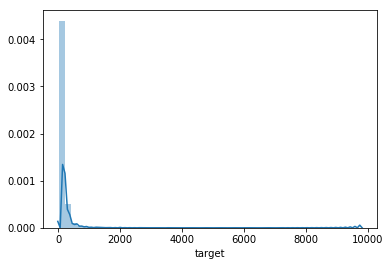

In [101]:
vis.histogram(data, 'target')

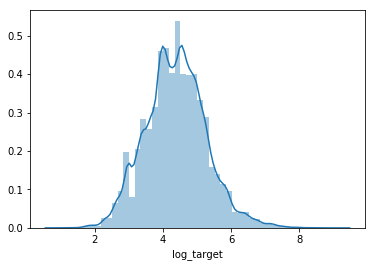

In [102]:
vis.histogram(data, 'log_target')

### Covariates groups
#### 1. Localization and transportation costs
- order_freight_value numeric
- product_weight_g numeric
- delivery_delay numeric
- lat numeric
- lng numeric
- seller_lat numeric
- seller_lng numeric

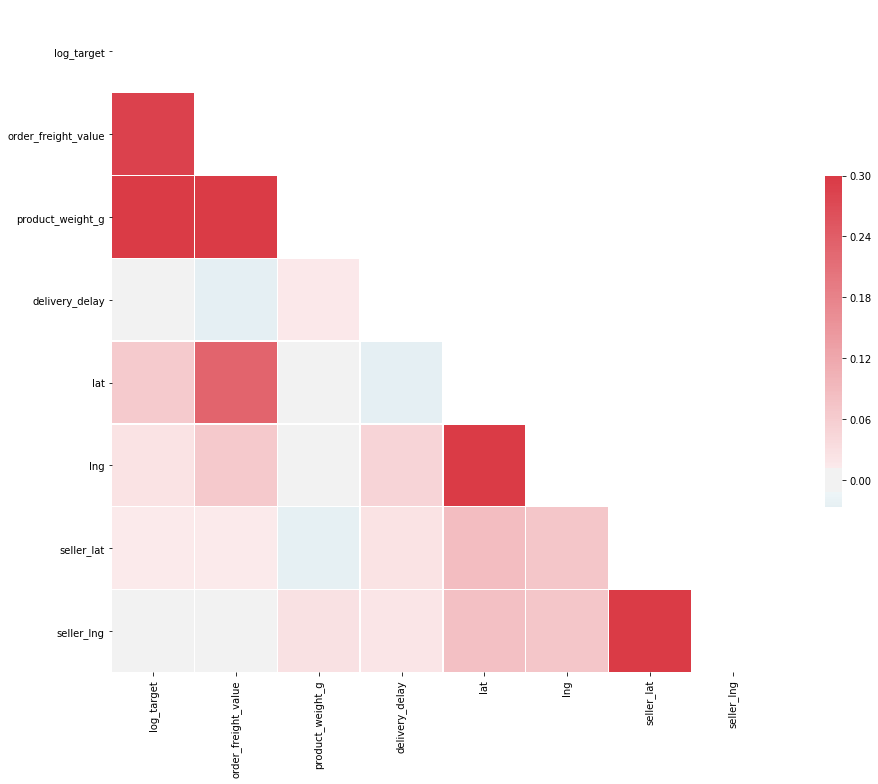

In [103]:
covariates_names = ['order_freight_value', 'product_weight_g', 'delivery_delay',\
                    'lat', 'lng', 'seller_lat', 'seller_lng']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

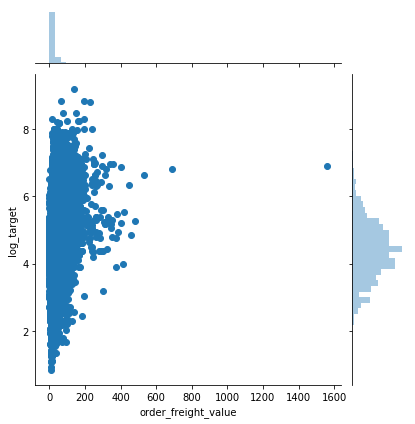

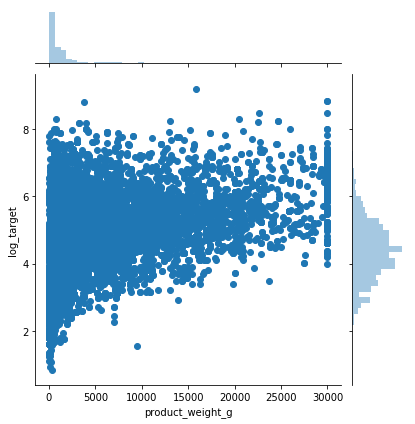

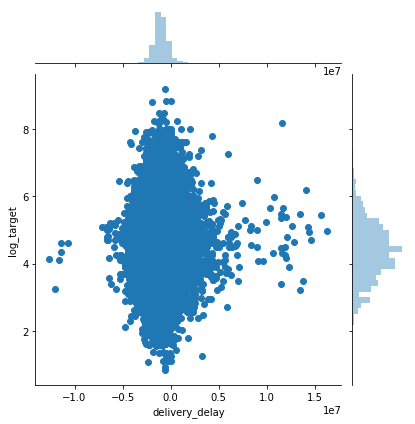

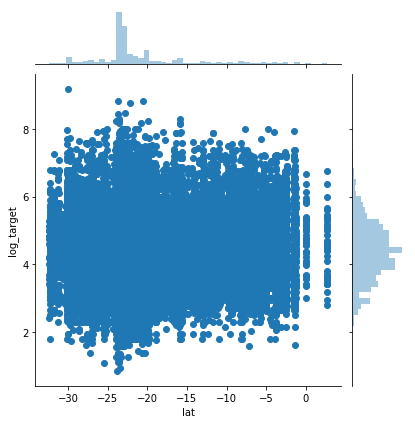

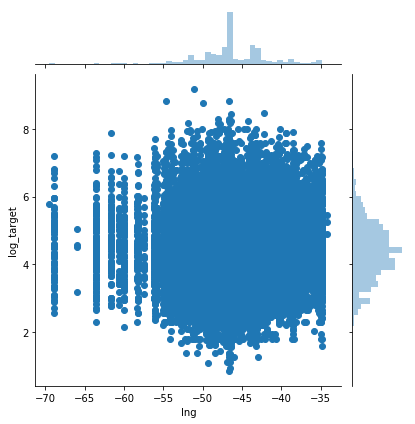

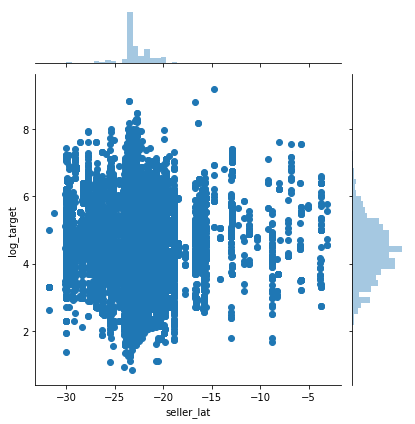

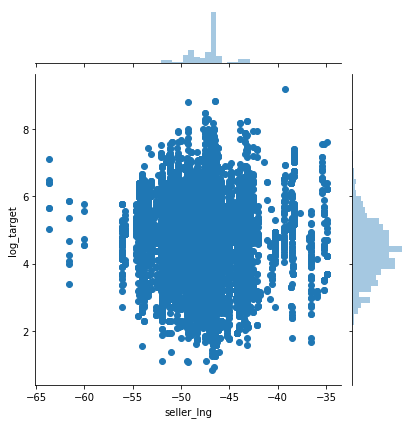

[None, None, None, None, None, None, None]

In [104]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in covariates_names]

Index(['order_freight_value', 'product_weight_g', 'delivery_delay', 'lat',
       'lng', 'seller_lat', 'seller_lng', 'order_freight_value_power_2',
       'product_weight_g_power_2', 'delivery_delay_power_2', 'lat_power_2',
       'lng_power_2', 'seller_lat_power_2', 'seller_lng_power_2',
       'order_freight_value_product_weight_g',
       'order_freight_value_delivery_delay', 'order_freight_value_lat',
       'order_freight_value_lng', 'order_freight_value_seller_lat',
       'order_freight_value_seller_lng', 'product_weight_g_delivery_delay',
       'product_weight_g_lat', 'product_weight_g_lng',
       'product_weight_g_seller_lat', 'product_weight_g_seller_lng',
       'delivery_delay_lat', 'delivery_delay_lng', 'delivery_delay_seller_lat',
       'delivery_delay_seller_lng', 'lat_lng', 'lat_seller_lat',
       'lat_seller_lng', 'lng_seller_lat', 'lng_seller_lng',
       'seller_lat_seller_lng'],
      dtype='object')
Computing regularization path using the coordinate descent las

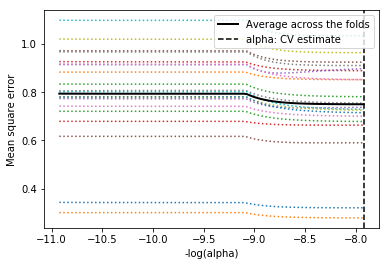

In [105]:
power_levels = [2]
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'log_target'].values)

In [106]:
#alphas = np.linspace(start=5, stop= selected_alpha, num=50)
#for alpha in alphas:
#    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'log_target'].values)
features_to_drop = lasso_pruning(4000, augmented_data, data.loc[:, 'log_target'].values)

for feature in list(augmented_data.columns):
    if feature in features_to_drop:
        continue
    else:
        print(feature)


25 features dropped out of 35
product_weight_g_power_2
delivery_delay_power_2
order_freight_value_product_weight_g
order_freight_value_delivery_delay
product_weight_g_delivery_delay
product_weight_g_seller_lng
delivery_delay_lat
delivery_delay_lng
delivery_delay_seller_lat
delivery_delay_seller_lng


#### 2. Feedback
- review_time numeric
- review_comment_message numeric
- review_score_1 category
- review_score_2 category
- review_score_3 category
- review_score_4 category
- review_score_5 category
- comment__False category
- comment__True category

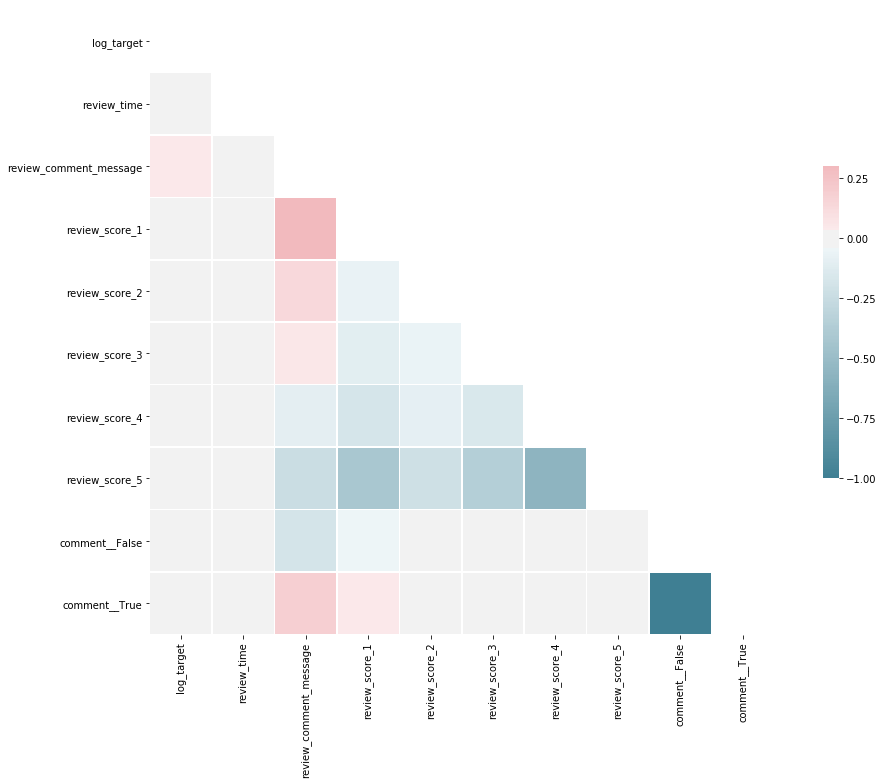

In [107]:
covariates_names = ['review_time', 'review_comment_message', 'review_score_1',\
                    'review_score_2', 'review_score_3', 'review_score_4', 'review_score_5',\
                   'comment__False', 'comment__True']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


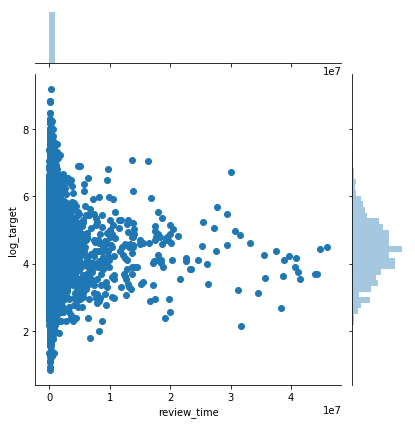

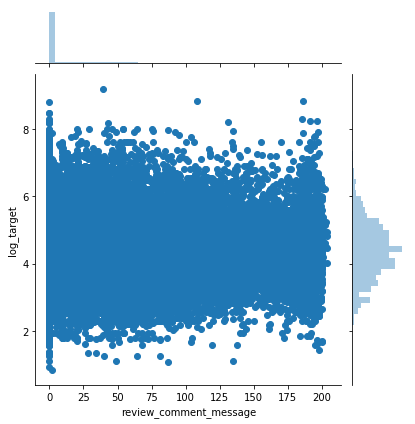

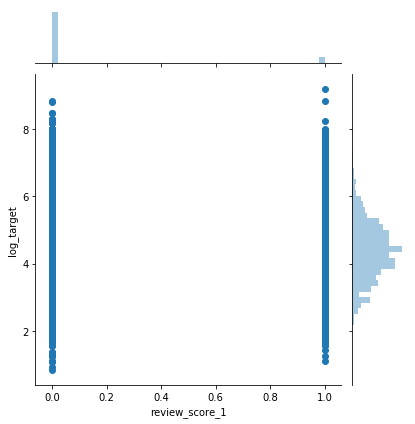

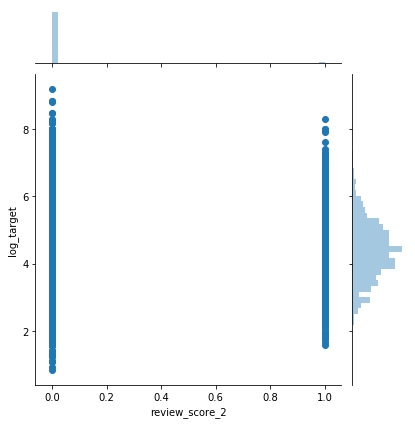

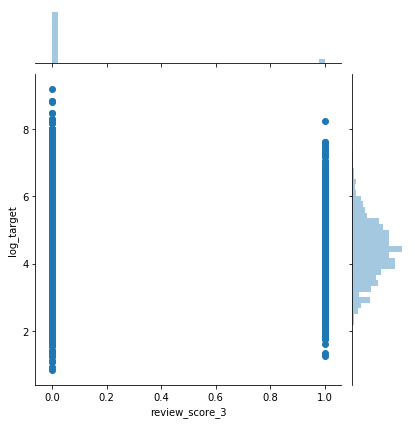

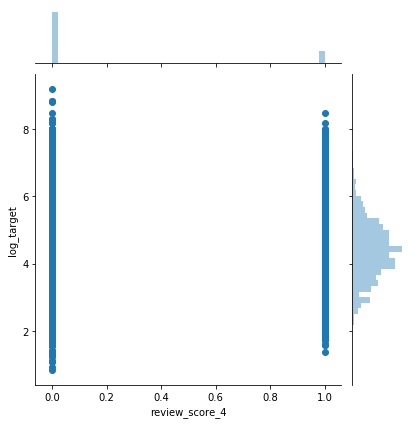

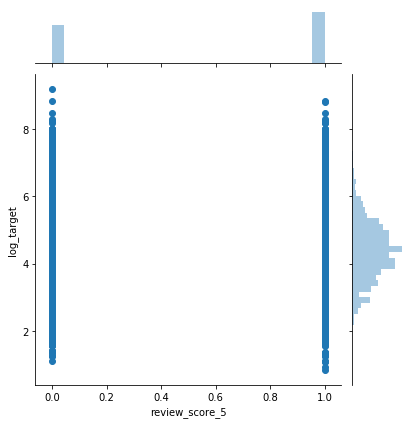

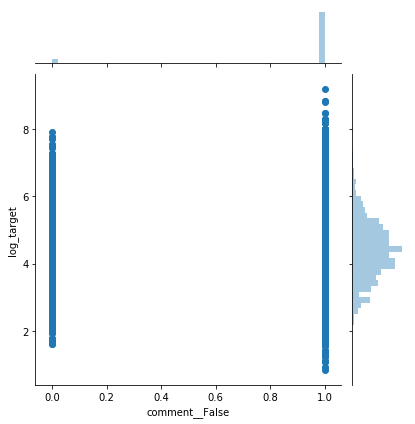

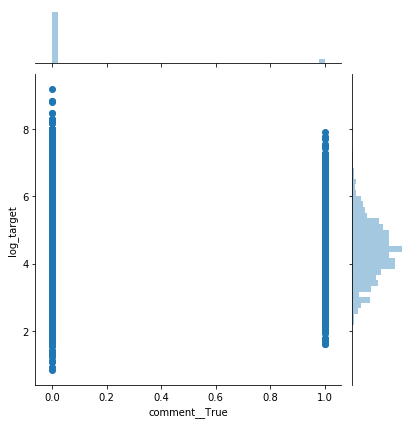

[None, None, None, None, None, None, None, None, None]

In [108]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in covariates_names]

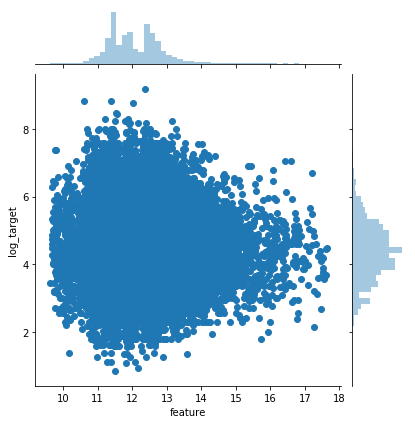

In [109]:
new_data = data.copy()
new_data = new_data.assign(feature = np.log(new_data.review_time))
vis.scatter_plots(new_data, 'feature', 'log_target')

Index(['review_time', 'review_comment_message', 'review_score_1',
       'review_score_2', 'review_score_3', 'review_score_4', 'review_score_5',
       'comment__False', 'comment__True', 'review_time_review_comment_message',
       'review_time_review_score_1', 'review_time_review_score_2',
       'review_time_review_score_3', 'review_time_review_score_4',
       'review_time_review_score_5', 'review_time_comment__False',
       'review_time_comment__True', 'review_comment_message_review_score_1',
       'review_comment_message_review_score_2',
       'review_comment_message_review_score_3',
       'review_comment_message_review_score_4',
       'review_comment_message_review_score_5',
       'review_comment_message_comment__False',
       'review_comment_message_comment__True', 'review_score_1_review_score_2',
       'review_score_1_review_score_3', 'review_score_1_review_score_4',
       'review_score_1_review_score_5', 'review_score_1_comment__False',
       'review_score_1_comment_

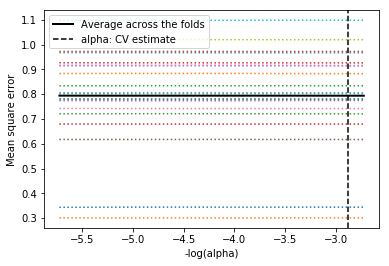

In [110]:
power_levels = []
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'log_target'].values)

In [78]:
#alphas = np.linspace(start=5, stop= selected_alpha, num=50)
#for alpha in alphas:
#    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'log_target'].values)
features_to_drop = lasso_pruning(selected_alpha, augmented_data, data.loc[:, 'log_target'].values)
#print(features_to_drop)
for feature in list(augmented_data.columns):
    if feature in features_to_drop:
        continue
    else:
        print(feature)

39 features dropped out of 45
review_time
review_time_review_comment_message
review_time_review_score_3
review_time_review_score_4
review_time_review_score_5
review_time_comment__False


#### 3. Care about product description
- product_description_lenght numeric
- product_photos_qty_0 category
- product_photos_qty_1 category
- product_photos_qty_2 category

In [111]:
data.columns

Index(['order_freight_value', 'product_description_lenght',
       'review_comment_message', 'approval_time', 'delivery_delay',
       'review_time', 'lat', 'lng', 'seller_lat', 'seller_lng',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'review_score_1', 'review_score_2',
       'review_score_3', 'review_score_4', 'review_score_5', 'comment__False',
       'comment__True', 'product_photos_qty_0', 'product_photos_qty_1',
       'product_photos_qty_2', 'target', 'log_target',
       'order_freight_value_power_2', 'product_weight_g_power_2',
       'delivery_delay_power_2', 'lat_power_2', 'lng_power_2',
       'seller_lat_power_2', 'seller_lng_power_2',
       'order_freight_value_product_weight_g',
       'order_freight_value_delivery_delay', 'order_freight_value_lat',
       'order_freight_value_lng', 'order_freight_value_seller_lat',
       'order_freight_value_seller_lng', 'product_weight_g_delivery_delay',
       'product_weight_g_la

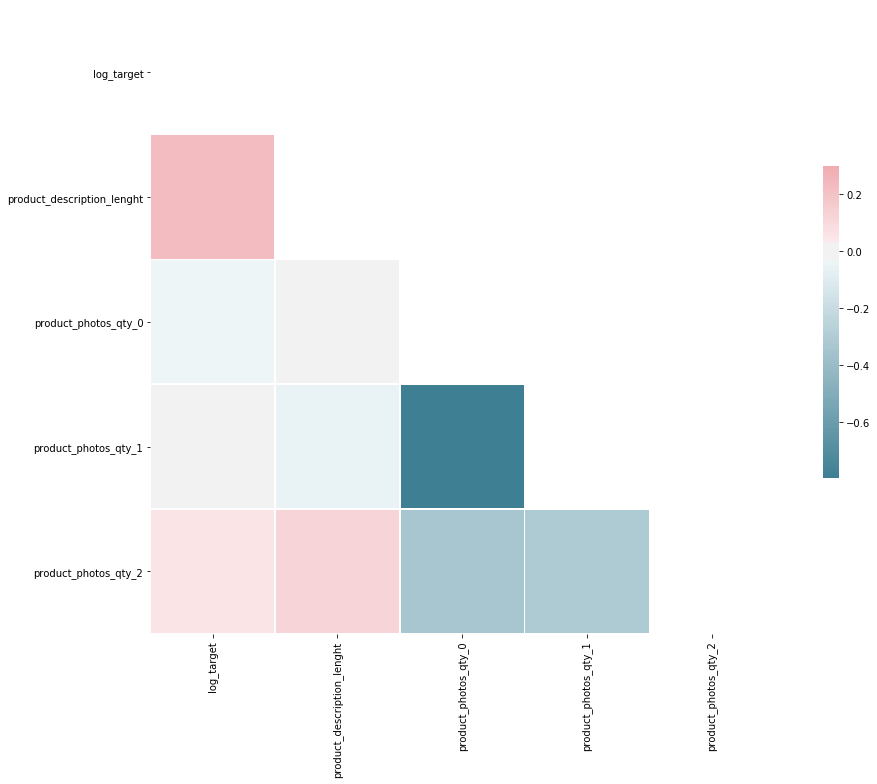

In [112]:
covariates_names = ['product_description_lenght', 'product_photos_qty_0',\
                    'product_photos_qty_1', 'product_photos_qty_2']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


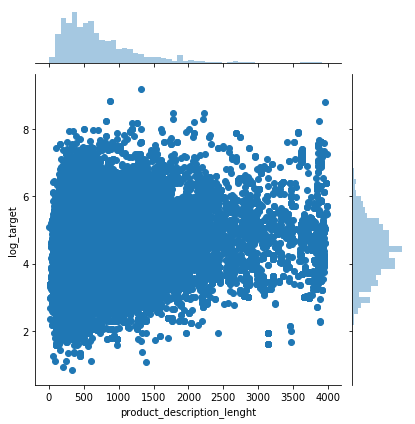

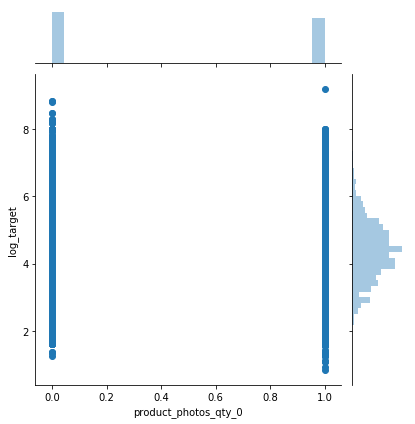

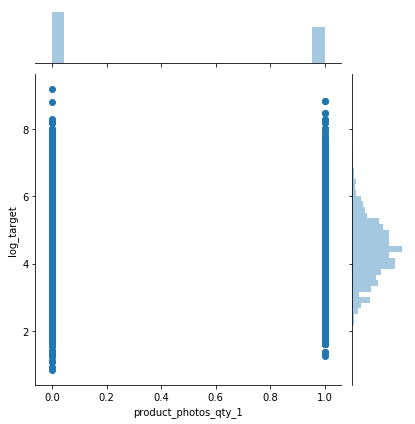

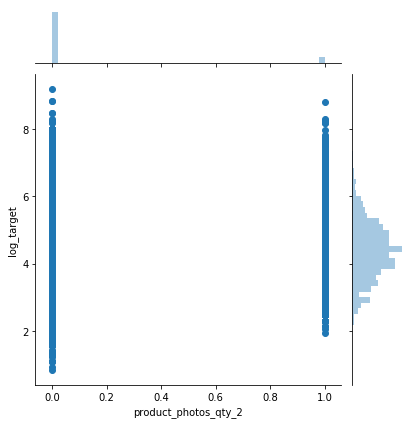

[None, None, None, None]

In [113]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in covariates_names]

Index(['product_description_lenght', 'product_photos_qty_0',
       'product_photos_qty_1', 'product_photos_qty_2',
       'product_description_lenght_product_photos_qty_0',
       'product_description_lenght_product_photos_qty_1',
       'product_description_lenght_product_photos_qty_2',
       'product_photos_qty_0_product_photos_qty_1',
       'product_photos_qty_0_product_photos_qty_2',
       'product_photos_qty_1_product_photos_qty_2'],
      dtype='object')
Computing regularization path using the coordinate descent lasso...
0.13986905597128474 is the alpha parameter retained for Lasso


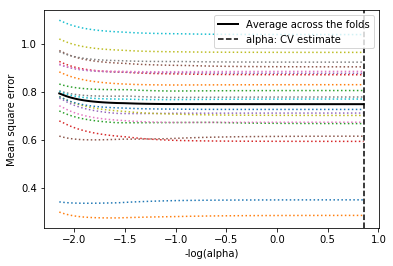

In [114]:
power_levels = []
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'log_target'].values)

In [115]:
#alphas = np.linspace(start=5, stop= selected_alpha, num=50)
#for alpha in alphas:
#    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'log_target'].values)
features_to_drop = lasso_pruning(0.005, augmented_data, data.loc[:, 'log_target'].values)
print(features_to_drop)

4 features dropped out of 10
['product_photos_qty_0', 'product_photos_qty_0_product_photos_qty_1', 'product_photos_qty_0_product_photos_qty_2', 'product_photos_qty_1_product_photos_qty_2']


/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### 4. Product dimensions
- product_weight_g numeric
- product_length_cm numeric
- product_height_cm numeric
- product_width_cm numeric

In [116]:
data.columns

Index(['order_freight_value', 'product_description_lenght',
       'review_comment_message', 'approval_time', 'delivery_delay',
       'review_time', 'lat', 'lng', 'seller_lat', 'seller_lng',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'review_score_1', 'review_score_2',
       'review_score_3', 'review_score_4', 'review_score_5', 'comment__False',
       'comment__True', 'product_photos_qty_0', 'product_photos_qty_1',
       'product_photos_qty_2', 'target', 'log_target',
       'order_freight_value_power_2', 'product_weight_g_power_2',
       'delivery_delay_power_2', 'lat_power_2', 'lng_power_2',
       'seller_lat_power_2', 'seller_lng_power_2',
       'order_freight_value_product_weight_g',
       'order_freight_value_delivery_delay', 'order_freight_value_lat',
       'order_freight_value_lng', 'order_freight_value_seller_lat',
       'order_freight_value_seller_lng', 'product_weight_g_delivery_delay',
       'product_weight_g_la

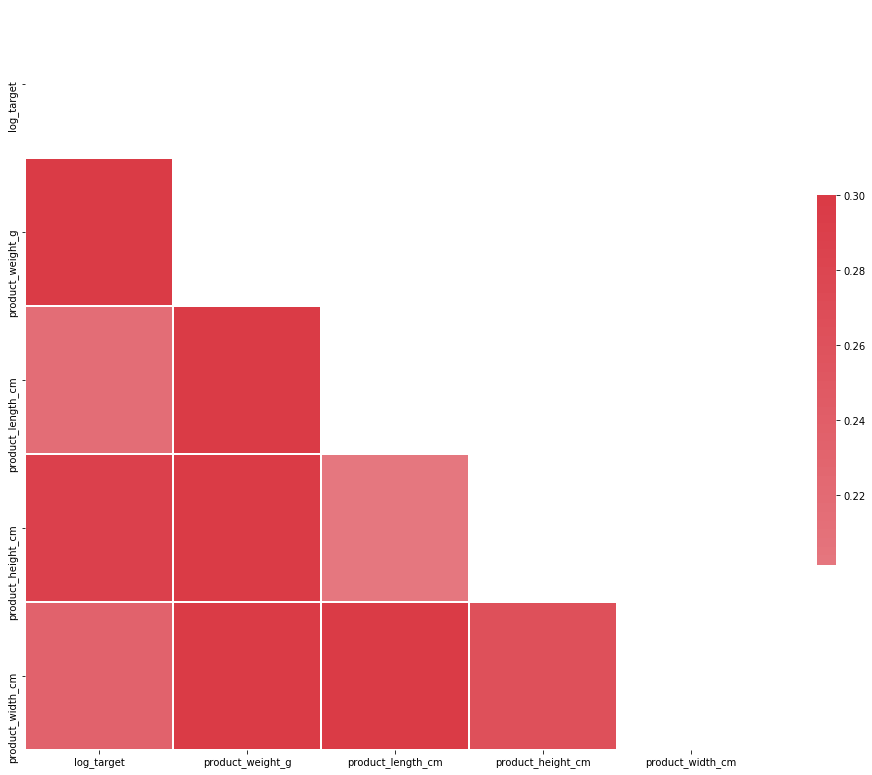

In [117]:
covariates_names = ['product_weight_g', 'product_length_cm',\
                    'product_height_cm', 'product_width_cm']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


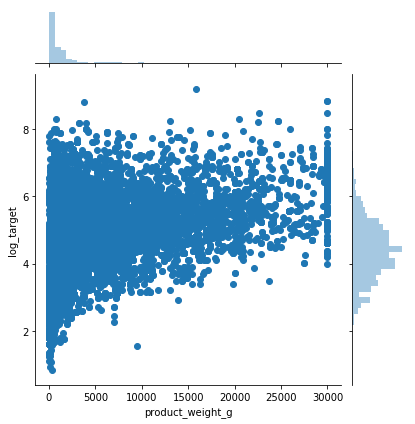

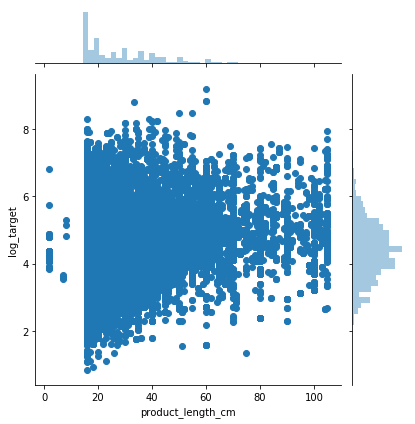

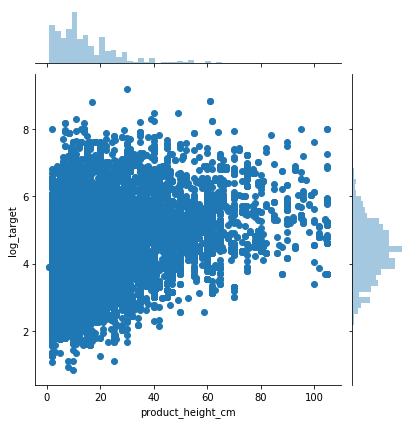

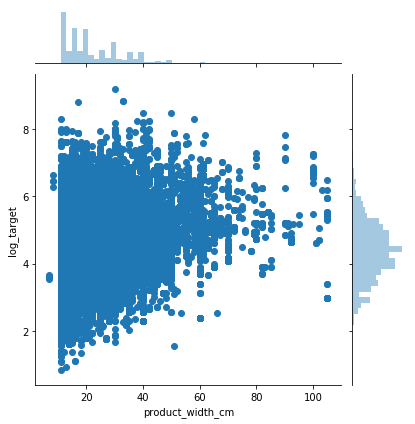

[None, None, None, None]

In [118]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in covariates_names]

- Not able to insulate the outliers in prices
- To some extent higher weight and medium width seem to correlate with high variance in prices
- correlations below 0.3

In [119]:
power_levels = [2]

Index(['product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_weight_g_power_2',
       'product_length_cm_power_2', 'product_height_cm_power_2',
       'product_width_cm_power_2', 'product_weight_g_product_length_cm',
       'product_weight_g_product_height_cm',
       'product_weight_g_product_width_cm',
       'product_length_cm_product_height_cm',
       'product_length_cm_product_width_cm',
       'product_height_cm_product_width_cm'],
      dtype='object')
Computing regularization path using the coordinate descent lasso...
101297.05439357353 is the alpha parameter retained for Lasso


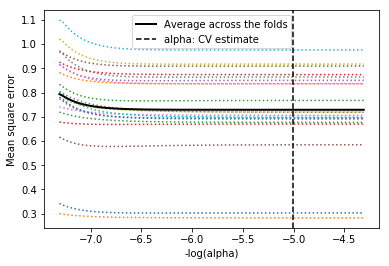

In [121]:
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'log_target'].values)

In [122]:
#alphas = np.linspace(start=5, stop= selected_alpha, num=50)
#for alpha in alphas:
#    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'log_target'].values)
features_to_drop = lasso_pruning(8, augmented_data, data.loc[:, 'log_target'].values)
print(features_to_drop)

7 features dropped out of 14
['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_length_cm_power_2', 'product_height_cm_power_2', 'product_width_cm_power_2', 'product_length_cm_product_width_cm']


#### 5. Processing time
- approval_time numeric
- delivery_delay numeric

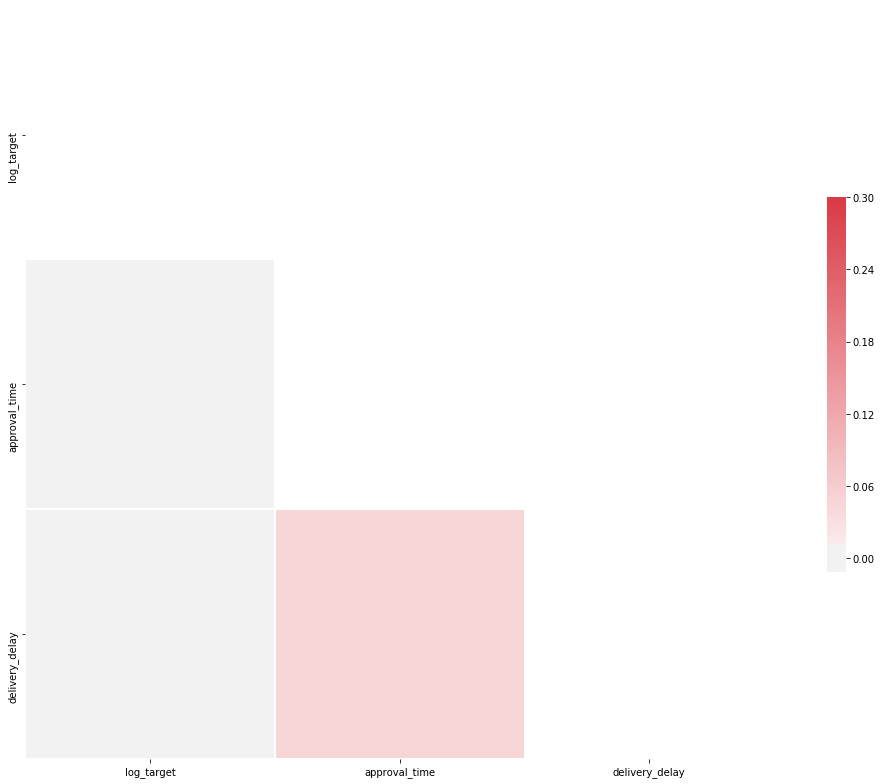

In [123]:
covariates_names = ['approval_time', 'delivery_delay']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


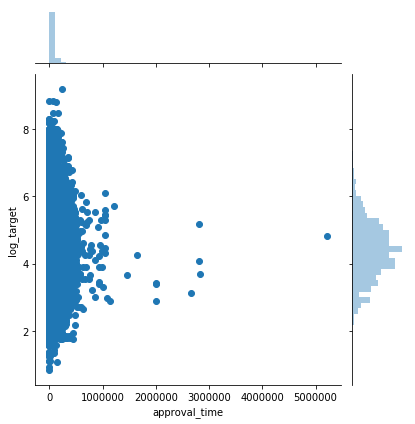

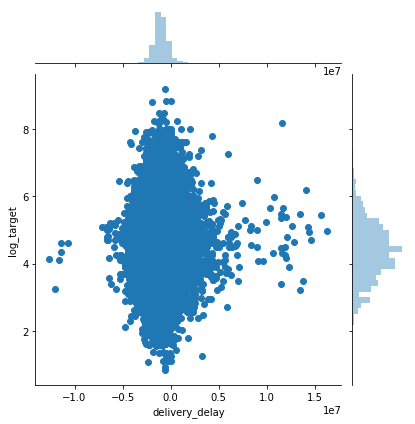

[None, None]

In [124]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in covariates_names]

Index(['approval_time', 'delivery_delay', 'approval_time_delivery_delay'], dtype='object')
Computing regularization path using the coordinate descent lasso...
5744776.776979216 is the alpha parameter retained for Lasso


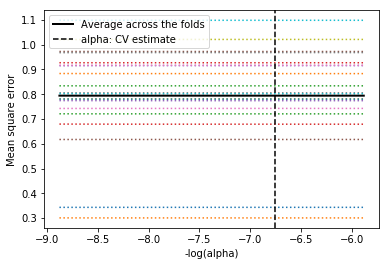

In [125]:
power_levels = []
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'log_target'].values)

/home/arnaud15/miniconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


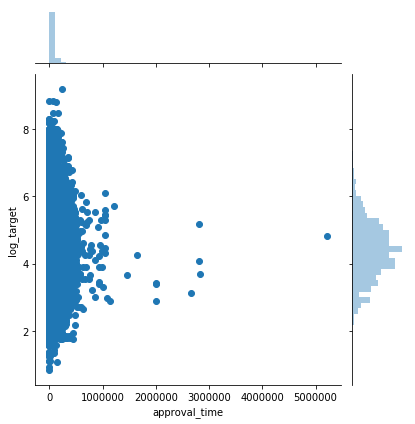

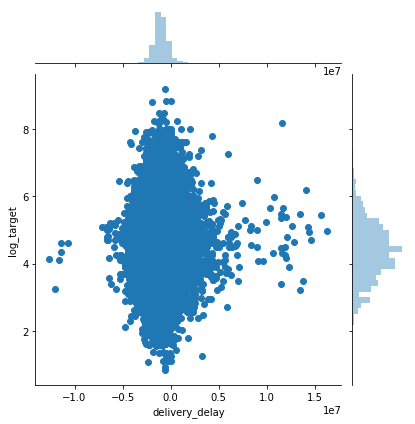

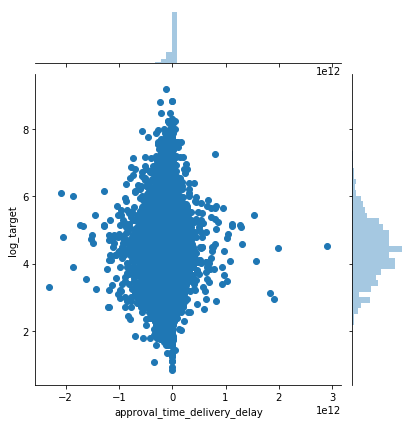

[None, None, None]

In [126]:
[vis.scatter_plots(data, cov_name, 'log_target') for cov_name in list(augmented_data.columns)]

In [127]:
augmented_data.columns

Index(['approval_time', 'delivery_delay', 'approval_time_delivery_delay'], dtype='object')

In [128]:
alphas = np.linspace(start=5, stop= selected_alpha, num=50)
for alpha in alphas:
    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'log_target'].values)
features_to_drop = lasso_pruning(10000, augmented_data, data.loc[:, 'log_target'].values)
print(features_to_drop)

0 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped out of 3
2 features dropped o